# OpenCV Shape Detection in HP AI Studio

This notebook implements shape detection using OpenCV's contour approximation method.

**Features:**
- Detects triangles, rectangles, squares, pentagons, and circles
- Uses contour approximation for shape identification
- MLflow tracking for experiment logging
- Interactive visualization of results
 
**Platform:** HP AI Studio with Deep Learning Workspace

## 1. System Dependencies Setup (Run First)

⚠️ **Important:** Run this cell at the start of each workspace session to ensure all system dependencies are installed.

In [1]:
import subprocess
import sys

# Install system dependencies (these don't persist in HP AI Studio)
print("Installing system dependencies for OpenCV...")
print("This may take 30-60 seconds...\n")

try:
    # Update package lists
    subprocess.run(['sudo', 'apt-get', 'update', '-qq'], check=True)
    print("✓ Package lists updated")
    
    # Install OpenGL libraries (required for cv2)
    subprocess.run(['sudo', 'apt-get', 'install', '-y', '-qq',
                    'libgl1-mesa-glx',      # OpenGL library (fixes libGL.so.1 error)
                    'libglib2.0-0',         # GLib library
                    'libsm6',               # Session Management library
                    'libxext6',             # X11 extensions
                    'libxrender-dev',       # X Rendering Extension
                    'libgomp1',             # OpenMP library
                    'libglib2.0-0'],        # Additional dependencies
                   check=True)
    print("✓ OpenGL and X11 libraries installed")
    
    # Install image format libraries (optional but recommended)
    subprocess.run(['sudo', 'apt-get', 'install', '-y', '-qq',
                    'libjpeg-dev', 'libpng-dev', 'libtiff-dev'], 
                   check=True)
    print("✓ Image format libraries installed")
    
    print("\n✓ All system dependencies installed successfully!")
    print("  OpenCV should now work correctly.\n")
    
except subprocess.CalledProcessError as e:
    print(f"\n⚠ Warning: System dependency installation failed: {e}")
    print("  Trying to continue anyway...")
except Exception as e:
    print(f"\n⚠ Warning: Unexpected error: {e}")
    print("  Trying to continue anyway...")

Installing system dependencies for OpenCV...
This may take 30-60 seconds...

✓ Package lists updated


debconf: delaying package configuration, since apt-utils is not installed


(Reading database ... 22266 files and directories currently installed.)
Preparing to unpack .../libatomic1_12.3.0-1ubuntu1~22.04.2_amd64.deb ...
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04.2) over (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../libubsan1_12.3.0-1ubuntu1~22.04.2_amd64.deb ...
Unpacking libubsan1:amd64 (12.3.0-1ubuntu1~22.04.2) over (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04.2_amd64.deb ...
Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04.2) over (12.3.0-1ubuntu1~22.04) ...
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04.2) ...
(Reading database ... 22266 files and directories currently installed.)
Preparing to unpack .../libstdc++6_12.3.0-1ubuntu1~22.04.2_amd64.deb ...
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04.2) over (12.3.0-1ubuntu1~22.04) ...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04.2) ...
(Reading database ... 22266 files and directories currently installed.)
Preparing to unpack .../0-libqu

debconf: delaying package configuration, since apt-utils is not installed


Selecting previously unselected package libdeflate-dev:amd64.
(Reading database ... 22790 files and directories currently installed.)
Preparing to unpack .../00-libdeflate-dev_1.10-2_amd64.deb ...
Unpacking libdeflate-dev:amd64 (1.10-2) ...
Selecting previously unselected package libjpeg-turbo8-dev:amd64.
Preparing to unpack .../01-libjpeg-turbo8-dev_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8-dev:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libjpeg8-dev:amd64.
Preparing to unpack .../02-libjpeg8-dev_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg8-dev:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package libjpeg-dev:amd64.
Preparing to unpack .../03-libjpeg-dev_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg-dev:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package zlib1g-dev:amd64.
Preparing to unpack .../04-zlib1g-dev_1%3a1.2.11.dfsg-2ubuntu9.2_amd64.deb ...
Unpacking zlib1g-dev:amd64 (1:1.2.11.dfsg-2ubuntu9.2) ...
Selecting previously

## 2. Quick Fix (If you get libGL.so.1 error)

If you already ran the imports and got the `libGL.so.1` error, run this cell to fix it immediately:

In [1]:
# Emergency fix for libGL.so.1 error
import subprocess

print("Installing missing OpenGL library...")
try:
    subprocess.run(['sudo', 'apt-get', 'update', '-qq'], check=True)
    subprocess.run(['sudo', 'apt-get', 'install', '-y', 'libgl1-mesa-glx'], check=True)
    print("✓ Fixed! Now restart the kernel and run all cells from the beginning.")
    print("  (Kernel → Restart Kernel in the menu)")
except Exception as e:
    print(f"Error: {e}")

Installing missing OpenGL library...
Reading package lists...
Building dependency tree...
Reading state information...
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.
✓ Fixed! Now restart the kernel and run all cells from the beginning.
  (Kernel → Restart Kernel in the menu)


## 3. Install Python Packages

These packages persist across workspace restarts in HP AI Studio.

In [1]:
# Install required packages (these persist in HP AI Studio)
!pip install opencv-python==4.8.0.76 imutils==0.5.4 matplotlib numpy --quiet
print("✓ Python packages installed")

✓ Python packages installed


## 4. Import Libraries

In [2]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import mlflow
import mlflow.pyfunc
from datetime import datetime

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

print(f"OpenCV Version: {cv2.__version__}")
print(f"imutils Version: {imutils.__version__}")
print("✓ All libraries imported successfully")

OpenCV Version: 4.8.0
imutils Version: 0.5.4
✓ All libraries imported successfully


## 5. Shape Detector Class

This class implements the shape detection algorithm using contour approximation.

In [3]:
class ShapeDetector:
    """
    Shape detector using contour approximation.
    
    Methods:
        detect(c): Identifies shape from contour
    """
    
    def __init__(self):
        pass
    
    def detect(self, c):
        """
        Detect shape from contour using vertex counting.
        
        Args:
            c: OpenCV contour
            
        Returns:
            str: Shape name (triangle, rectangle, square, pentagon, circle)
        """
        # Initialize shape name
        shape = "unidentified"
        
        # Calculate perimeter and approximate contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        # Shape identification based on number of vertices
        if len(approx) == 3:
            shape = "triangle"
            
        elif len(approx) == 4:
            # Compute bounding box and aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            shape = "square"
            
        elif len(approx) == 5:
            shape = "pentagon"
            
        else:
            # Assume circle for shapes with many vertices
            shape = "circle"
            
        return shape

print("✓ ShapeDetector class defined")

✓ ShapeDetector class defined


## 6. Image Processing Functions

In [4]:
def preprocess_image(image, resize_width=300):
    """
    Preprocess image for shape detection.
    
    Args:
        image: Input image (BGR)
        resize_width: Target width for resizing
        
    Returns:
        tuple: (resized_image, ratio, gray, blurred, thresh)
    """
    # Resize image
    resized = imutils.resize(image, width=resize_width)
    ratio = image.shape[0] / float(resized.shape[0])
    
    # Convert to grayscale
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Threshold to create binary image
    thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]
    #thresh = gray
    
    return resized, ratio, gray, blurred, thresh


def detect_shapes_in_image(image_path, visualize=True):
    """
    Detect shapes in an image and optionally visualize results.
    
    Args:
        image_path: Path to input image
        visualize: Whether to display results
        
    Returns:
        dict: Detection results with shape counts and image
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Preprocess
    resized, ratio, gray, blurred, thresh = preprocess_image(image)
    
    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # Initialize shape detector and results
    sd = ShapeDetector()
    shape_counts = {}
    
    # Process each contour
    for c in cnts:
        # Compute center of contour
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
            
        cX = int((M["m10"] / M["m00"]) * ratio)
        cY = int((M["m01"] / M["m00"]) * ratio)
        
        # Detect shape
        shape = sd.detect(c)
        
        # Update counts
        shape_counts[shape] = shape_counts.get(shape, 0) + 1
        
        # Scale contour back to original size
        c = c.astype("float")
        c *= ratio
        c = c.astype("int")
        
        # Draw contour and label
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
        #cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 2)
    
    # Visualize if requested
    if visualize:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Original preprocessed image
        axes[0, 0].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Original Resized Image')
        axes[0, 0].axis('off')
        
        # Thresholded image
        axes[0, 1].imshow(thresh, cmap='gray')
        axes[0, 1].set_title('Thresholded Image')
        axes[0, 1].axis('off')
        
        # Result with detections
        axes[1, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[1, 0].set_title('Detected Shapes')
        axes[1, 0].axis('off')
        
        # Shape counts bar chart
        if shape_counts:
            axes[1, 1].bar(shape_counts.keys(), shape_counts.values(), color='steelblue')
            axes[1, 1].set_title('Shape Distribution')
            axes[1, 1].set_xlabel('Shape Type')
            axes[1, 1].set_ylabel('Count')
            axes[1, 1].tick_params(axis='x', rotation=45)
        else:
            axes[1, 1].text(0.5, 0.5, 'No shapes detected', 
                           ha='center', va='center', fontsize=14)
            axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'image': image,
        'shape_counts': shape_counts,
        'total_shapes': sum(shape_counts.values()),
        'image_path': image_path
    }

print("✓ Image processing functions defined")

✓ Image processing functions defined


## 7. Configuration

Set your image path and MLflow experiment name here.

In [5]:
# Configuration
IMAGE_PATH = 'complex_96_160.png'  # Update this path
EXPERIMENT_NAME = 'shape_detection_opencv'
RESIZE_WIDTH = 300
THRESHOLD_VALUE = 60

# Set MLflow experiment
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"Configuration:")
print(f"  Image Path: {IMAGE_PATH}")
print(f"  Experiment: {EXPERIMENT_NAME}")
print(f"  Resize Width: {RESIZE_WIDTH}")
print(f"  Threshold: {THRESHOLD_VALUE}")

Configuration:
  Image Path: complex_96_160.png
  Experiment: shape_detection_opencv
  Resize Width: 300
  Threshold: 60


## 8. Run Shape Detection with MLflow Tracking

Running shape detection...


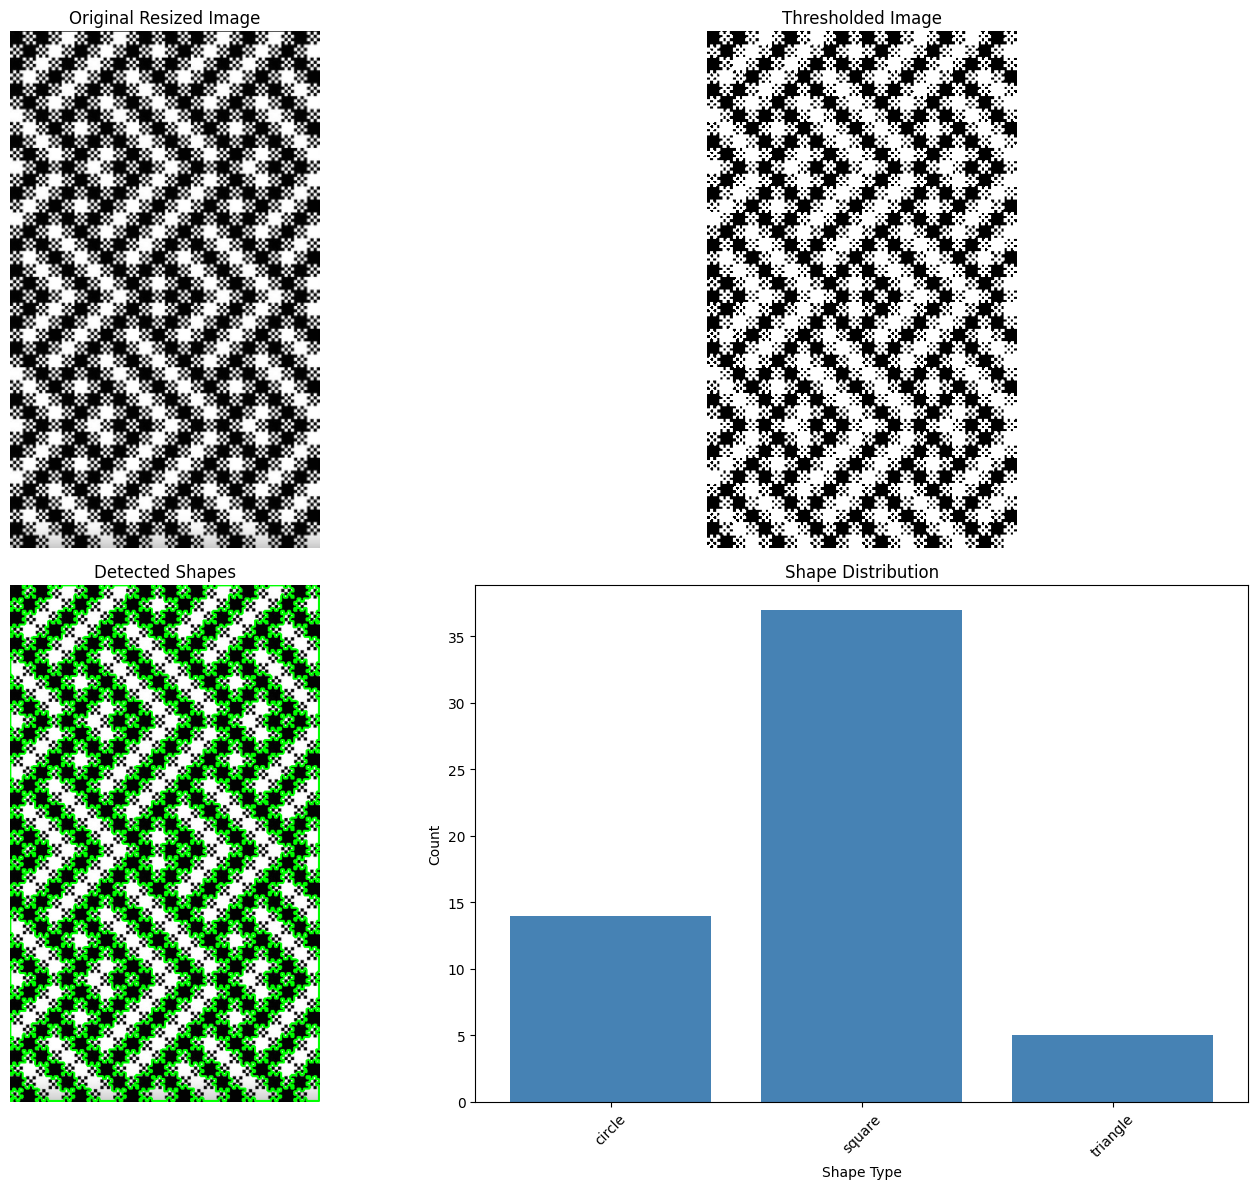


✓ Detection Complete!
  Total shapes detected: 56
  Shape distribution: {'circle': 14, 'square': 37, 'triangle': 5}

✓ Results logged to MLflow
  View results in the Monitor tab


In [6]:
# Start MLflow run
with mlflow.start_run(run_name=f"detection_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    
    # Log parameters
    mlflow.log_param("resize_width", RESIZE_WIDTH)
    mlflow.log_param("threshold_value", THRESHOLD_VALUE)
    mlflow.log_param("image_path", IMAGE_PATH)
    
    # Run detection
    print("Running shape detection...")
    results = detect_shapes_in_image(IMAGE_PATH, visualize=True)
    
    # Log metrics
    mlflow.log_metric("total_shapes", results['total_shapes'])
    for shape, count in results['shape_counts'].items():
        mlflow.log_metric(f"count_{shape}", count)
    
    # Log results as artifact
    print(f"\n✓ Detection Complete!")
    print(f"  Total shapes detected: {results['total_shapes']}")
    print(f"  Shape distribution: {results['shape_counts']}")
    
    # Save output image
    output_path = '/tmp/detected_shapes.png'
    cv2.imwrite(output_path, results['image'])
    mlflow.log_artifact(output_path, "output_images")
    
    print(f"\n✓ Results logged to MLflow")
    print(f"  View results in the Monitor tab")

## 9. Batch Processing Multiple Images

Process all images in a directory.

In [7]:
def batch_process_images(image_dir, output_dir='/tmp/batch_results'):
    """
    Process all images in a directory.
    
    Args:
        image_dir: Directory containing images
        output_dir: Directory to save results
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    image_files = [f for f in os.listdir(image_dir) 
                   if f.lower().endswith(valid_extensions)]
    
    print(f"Found {len(image_files)} images to process\n")
    
    # Process each image
    all_results = []
    
    with mlflow.start_run(run_name=f"batch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
        mlflow.log_param("batch_size", len(image_files))
        mlflow.log_param("image_directory", image_dir)
        
        for i, filename in enumerate(image_files, 1):
            image_path = os.path.join(image_dir, filename)
            print(f"[{i}/{len(image_files)}] Processing {filename}...")
            
            try:
                results = detect_shapes_in_image(image_path, visualize=False)
                all_results.append(results)
                
                # Save output
                output_path = os.path.join(output_dir, f'detected_{filename}')
                cv2.imwrite(output_path, results['image'])
                
                print(f"  ✓ {results['total_shapes']} shapes detected")
                
            except Exception as e:
                print(f"  ✗ Error: {e}")
        
        # Log aggregate metrics
        total_shapes = sum(r['total_shapes'] for r in all_results)
        mlflow.log_metric("total_shapes_all_images", total_shapes)
        mlflow.log_metric("avg_shapes_per_image", total_shapes / len(all_results) if all_results else 0)
        
        print(f"\n✓ Batch processing complete!")
        print(f"  Total shapes across all images: {total_shapes}")
        print(f"  Results saved to: {output_dir}")
    
    return all_results

# Example usage (uncomment to run):
# batch_results = batch_process_images('/path/to/image/directory')

## 10. Interactive Testing

Test the detector on sample shapes.

Creating test image with known shapes...
✓ Test image created at: /tmp/test_shapes.png

Running detection on test image...


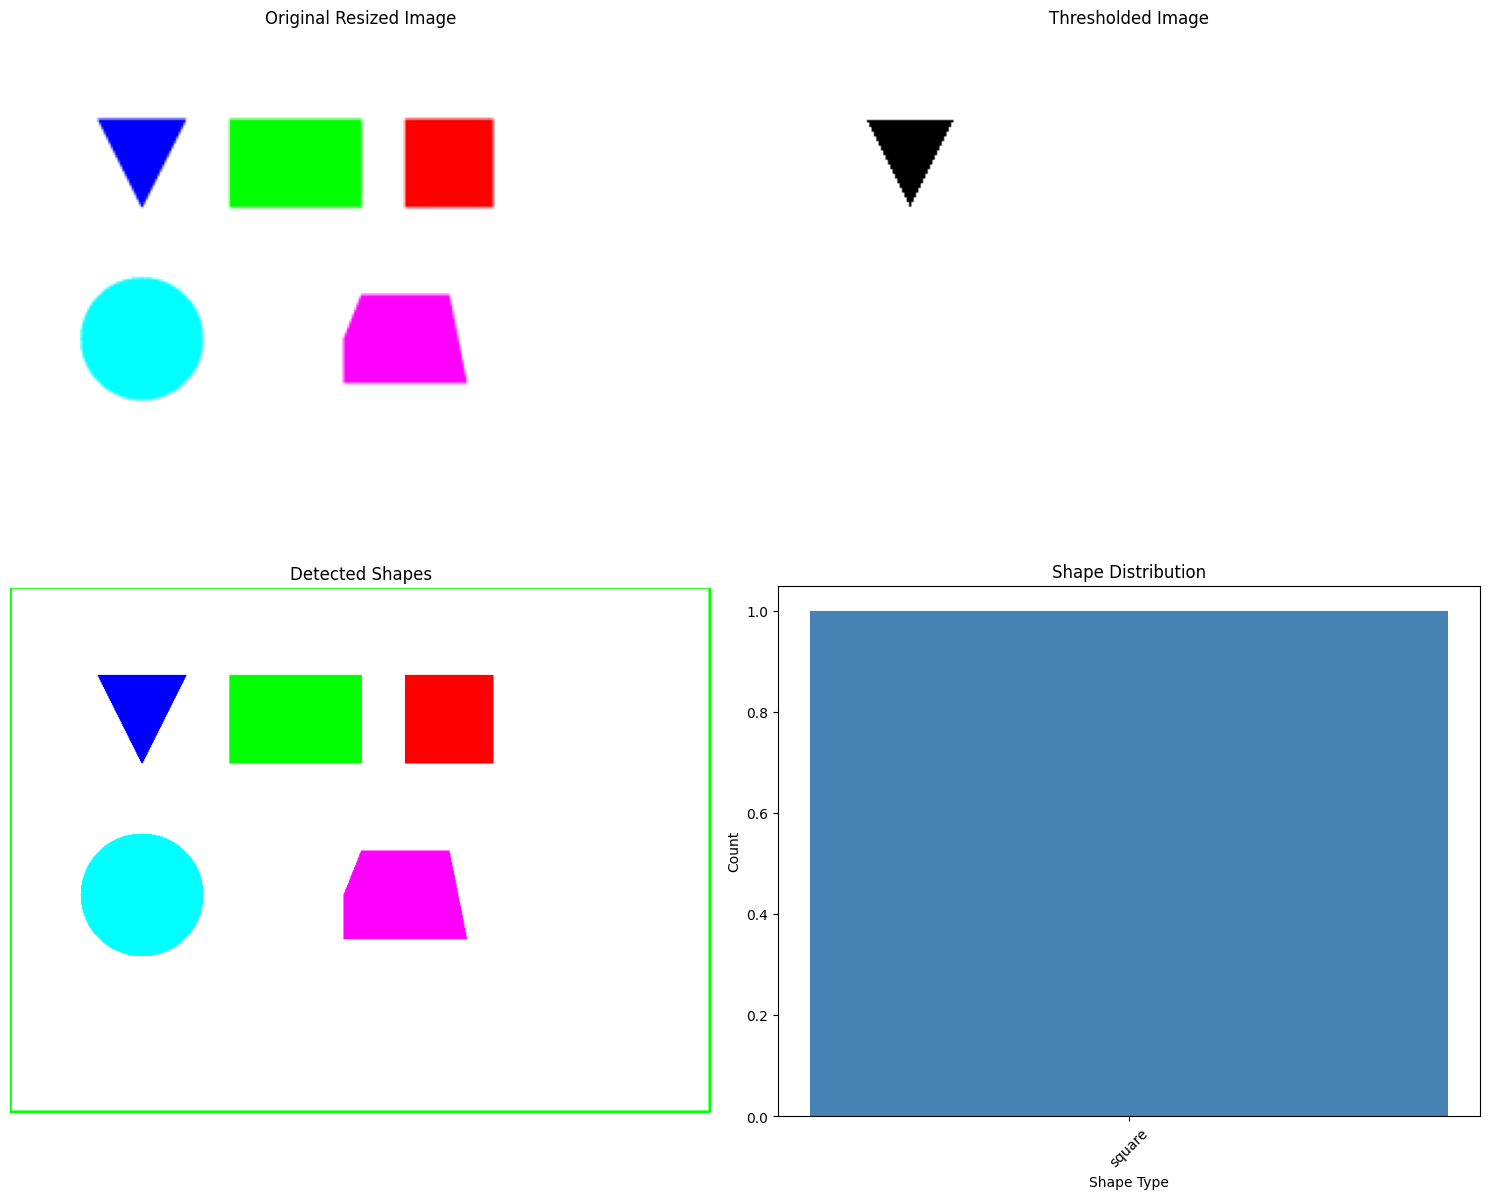

In [8]:
def create_test_image():
    """
    Create a test image with various shapes.
    """
    # Create blank white image
    img = np.ones((600, 800, 3), dtype=np.uint8) * 255
    
    # Draw shapes
    # Triangle
    pts = np.array([[100, 100], [200, 100], [150, 200]], np.int32)
    cv2.fillPoly(img, [pts], (255, 0, 0))
    
    # Rectangle
    cv2.rectangle(img, (250, 100), (400, 200), (0, 255, 0), -1)
    
    # Square
    cv2.rectangle(img, (450, 100), (550, 200), (0, 0, 255), -1)
    
    # Circle
    cv2.circle(img, (150, 350), 70, (255, 255, 0), -1)
    
    # Pentagon
    pts = np.array([[400, 300], [500, 300], [520, 400], [380, 400], [380, 350]], np.int32)
    cv2.fillPoly(img, [pts], (255, 0, 255))
    
    # Save test image
    test_path = '/tmp/test_shapes.png'
    cv2.imwrite(test_path, img)
    
    return test_path

# Create and test on synthetic image
print("Creating test image with known shapes...")
test_image_path = create_test_image()
print(f"✓ Test image created at: {test_image_path}")

# Run detection on test image
print("\nRunning detection on test image...")
test_results = detect_shapes_in_image(test_image_path, visualize=True)

## 11. Model Deployment Preparation

Prepare the shape detector for MLflow deployment.

In [ ]:
class ShapeDetectorModel(mlflow.pyfunc.PythonModel):
    """
    MLflow-compatible wrapper for ShapeDetector.
    """
    
    def load_context(self, context):
        """Initialize the detector."""
        self.detector = ShapeDetector()
    
    def predict(self, context, model_input):
        """
        Predict shapes in images.
        
        Args:
            model_input: DataFrame with 'image_path' column
            
        Returns:
            List of detection results
        """
        results = []
        
        for image_path in model_input['image_path']:
            try:
                result = detect_shapes_in_image(image_path, visualize=False)
                results.append(result['shape_counts'])
            except Exception as e:
                results.append({'error': str(e)})
        
        return results

# Register model with MLflow
with mlflow.start_run(run_name="model_registration"):
    mlflow.pyfunc.log_model(
        "shape_detector_model",
        python_model=ShapeDetectorModel(),
        pip_requirements=["opencv-python==4.8.0.76", "imutils==0.5.4", "numpy"]
    )
    print("✓ Model registered with MLflow")
    print("  Deploy via the Publish Services tab in HP AI Studio")

## 12. Summary and Next Steps

**What you've built:**
- ✓ Complete shape detection pipeline with OpenCV
- ✓ MLflow experiment tracking integration
- ✓ Batch processing capabilities
- ✓ Deployment-ready model wrapper

**Next steps:**
1. Upload your test images to HP AI Studio Assets tab
2. Update IMAGE_PATH in Cell 6 with your image location
3. Run all cells to detect shapes and track experiments
4. View results in the Monitor tab (MLflow)
5. Deploy model via Publish Services → Swagger API endpoint

**Tips:**
- Adjust THRESHOLD_VALUE (Cell 6) if shapes aren't detected correctly
- Use batch processing for multiple images
- Check MLflow dashboard for experiment comparisons
- Export workspace as Docker container for production deployment